In [1]:
%pip install aif360 pandas scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install "aif360[all]"

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.6 MB 1.0 MB/s eta 0:00:02
     ------------ --------------------------- 0.8/2.6 MB 1.0 MB/s eta 0:00:02
     ---------------- ----------------------- 1.0/2.6 MB 1.0 MB/s eta 0:00:02
     -------------------- ------------------- 1.3/2.6 MB 1.1 MB/s eta 0:00:02
     ------------------------ --------------- 1.6/2.6 MB 1.0 MB/s eta 0:00:01
     ------------------------ --------------- 1.6/2.6 MB 1.0 MB/s e

In [1]:
import pandas as pd
import numpy as np
import json

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

e:\5th SEM Data\AI254TA-Machine Learning Operations(MLOps)\MLOPs_Project\venv\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
e:\5th SEM Data\AI254TA-Machine Learning Operations(MLOps)\MLOPs_Project\venv\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more det

In [2]:
df = pd.read_csv("data/master_airquality_clean.csv", low_memory=False)

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df.dropna(subset=["Timestamp", "PM2.5"], inplace=True)

# Choose protected attribute (you can change)
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)  # 1 = weekend, 0 = weekday

df.head()

,Timestamp,PM2.5,PM10,O3,CO,Source,hour,dayofweek,is_weekend
0,2020-02-01,43.67,134.00,21.82,0.91,KaggleStation,0,5,1
1,2020-03-01,30.58,74.42,23.31,0.96,KaggleStation,0,6,1
2,2020-04-01,66.35,155.68,29.7,2.54,KaggleStation,0,2,0
3,2020-05-01,48.00,99.13,31.01,1.14,KaggleStation,0,4,0
4,2020-06-01,23.75,63.34,25.82,1.08,KaggleStation,0,0,0


In [3]:
# -----------------------------
# AIF360: Create Fairness Dataset (fixed)
# -----------------------------

df_fair = df.copy()

# Ensure protected attribute is numeric
df_fair["is_weekend"] = df_fair["is_weekend"].astype(int)

# Convert regression target to binary classification
median_value = df_fair["PM2.5"].median()
df_fair["label"] = (df_fair["PM2.5"] > median_value).astype(int)

# -------- FIX: REMOVE NON-NUMERIC COLUMNS --------
cols_to_drop = []

for col in df_fair.columns:
    if df_fair[col].dtype == 'object' or 'datetime' in str(df_fair[col].dtype):
        cols_to_drop.append(col)

print("Dropping columns (AIF360 incompatible):", cols_to_drop)

df_fair = df_fair.drop(columns=cols_to_drop)

# -------- FIX: REMOVE NaN rows --------
df_fair = df_fair.dropna()

# Protected attribute
protected_attribute = "is_weekend"

# Build dataset
dataset = StandardDataset(
    df=df_fair,
    label_name="label",
    favorable_classes=[0],
    protected_attribute_names=[protected_attribute],
    privileged_classes=[[0]]
)

dataset

Dropping columns (AIF360 incompatible): ['Timestamp', 'O3', 'CO', 'Source']


               instance weights features                          \
                                                                   
                                   PM2.5    PM10  hour dayofweek   
instance names                                                     
0                           1.0    43.67  134.00   0.0       5.0   
1                           1.0    30.58   74.42   0.0       6.0   
2                           1.0    66.35  155.68   0.0       2.0   
3                           1.0    48.00   99.13   0.0       4.0   
4                           1.0    23.75   63.34   0.0       0.0   
...                         ...      ...     ...   ...       ...   
12133997                    1.0    46.75   86.33  19.0       4.0   
12133998                    1.0    41.40   80.97  20.0       4.0   
12133999                    1.0    36.05   79.35  21.0       4.0   
12134000                    1.0    34.02   76.25  22.0       4.0   
12134001                    1.0    34.50   71.17

In [4]:
metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{protected_attribute: 0}],
    unprivileged_groups=[{protected_attribute: 1}]
)

governance_report = {
    "protected_attribute": protected_attribute,
    "dataset_size": int(len(df)),
    "PM25_median_threshold": float(median_value),
    "mean_difference": float(metric.mean_difference()),
    "disparate_impact": float(metric.disparate_impact()),
    "statistical_parity_difference": float(metric.statistical_parity_difference()),
}

governance_report

{'protected_attribute': 'is_weekend',
 'dataset_size': 12134002,
 'PM25_median_threshold': 45.5,
 'mean_difference': 0.007536511684952285,
 'disparate_impact': 1.013304634316174,
 'statistical_parity_difference': 0.007536511684952285}

In [5]:
with open("governance_report.json", "w") as f:
    json.dump(governance_report, f, indent=4)

print("✔ governance_report.json saved!")

✔ governance_report.json saved!


In [6]:
import os
print("governance_report.json exists:", os.path.exists("governance_report.json"))

governance_report.json exists: True


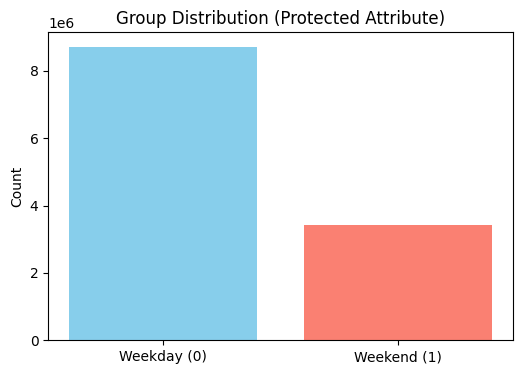

In [7]:
import matplotlib.pyplot as plt

group_counts = df_fair["is_weekend"].value_counts()
group_counts.index = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values, color=["skyblue", "salmon"])
plt.title("Group Distribution (Protected Attribute)")
plt.ylabel("Count")
plt.show()

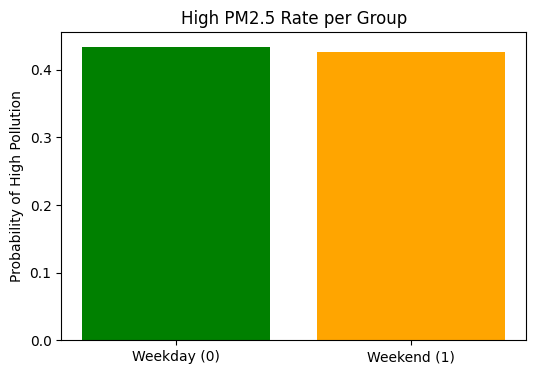

In [8]:
label_rates = df_fair.groupby("is_weekend")["label"].mean()
label_rates.index = ["Weekday (0)", "Weekend (1)"]

plt.figure(figsize=(6,4))
plt.bar(label_rates.index, label_rates.values, color=["green", "orange"])
plt.title("High PM2.5 Rate per Group")
plt.ylabel("Probability of High Pollution")
plt.show()

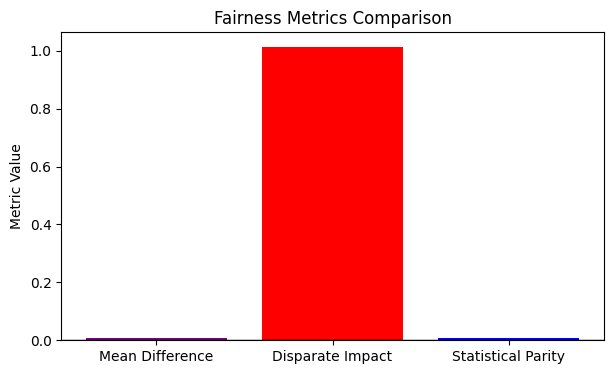

In [9]:
metrics = {
    "Mean Difference": governance_report["mean_difference"],
    "Disparate Impact": governance_report["disparate_impact"],
    "Statistical Parity": governance_report["statistical_parity_difference"]
}

plt.figure(figsize=(7,4))
plt.bar(metrics.keys(), metrics.values(), color=["purple", "red", "blue"])
plt.title("Fairness Metrics Comparison")
plt.ylabel("Metric Value")
plt.axhline(0, color="black", linewidth=1)
plt.show()